In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

# Data Consolidation for Optimization Modeling

In [102]:
#Trip prediction data for 1/31/2019
path = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trips_final_20190131.csv"
data = pd.read_csv(path)
data.head()

,Unnamed: 0,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,...,wind,precip_,start_dow_Friday,start_dow_Monday,start_dow_Saturday,start_dow_Sunday,start_dow_Thursday,start_dow_Tuesday,start_dow_Wednesday,trip_count_predicted
0,118630,2019-01-31,0,116,Mississippi St at 17th St,31.0,True,93,4th St at Mission Bay Blvd S,27.0,...,6.0,0.0,0,0,0,0,1,0,0,1.094604
1,118631,2019-01-31,0,285,Webster St at O'Farrell St,27.0,True,61,Howard St at 8th St,27.0,...,6.0,0.0,0,0,0,0,1,0,0,1.079082
2,118632,2019-01-31,1,380,Masonic Ave at Turk St,23.0,True,52,McAllister St at Baker St,27.0,...,5.0,0.0,0,0,0,0,1,0,0,1.085881
3,118633,2019-01-31,2,78,Folsom St at 9th St,27.0,True,321,5th St at Folsom,31.0,...,5.0,0.0,0,0,0,0,1,0,0,1.078276
4,118634,2019-01-31,3,36,Folsom St at 3rd St,31.0,True,14,Clay St at Battery St,31.0,...,0.0,0.0,0,0,0,0,1,0,0,1.008814


In [103]:
bikes_out = data.groupby(['start_station_id'])['trip_count_predicted'].sum()   #Total bikes predicted to leave each station on this day
bikes_in = data.groupby(['end_station_id'])['trip_count_predicted'].sum()      #Total bikes predicted to enter each station on this day
bike_flow = pd.concat([bikes_out, bikes_in], axis=1)
bike_flow.columns = ['bikes_out','bikes_in']

#net daily change in bikes - we want to keep this number as close to zero as possible
bike_flow['net'] = bike_flow['bikes_out'] - bike_flow['bikes_in']
bike_flow = bike_flow.dropna()
bike_flow.head()

,bikes_out,bikes_in,net
3,153.302030,143.346334,9.955697
4,35.120508,32.180798,2.939711
5,103.705740,103.043821,0.661919
6,111.785342,146.316629,-34.531287
8,39.156881,54.135994,-14.979113


# Filter data to focus on most critically imbalanced stations

In [104]:
minflow, maxflow = -10, 10

I decided to focus on stations with a net bike flow outside of the range (-10,10) because those are the most unbalanced, and an LP solver will take far too long if it included every station. A plot below shows red dots, which will be the stations to focus on.

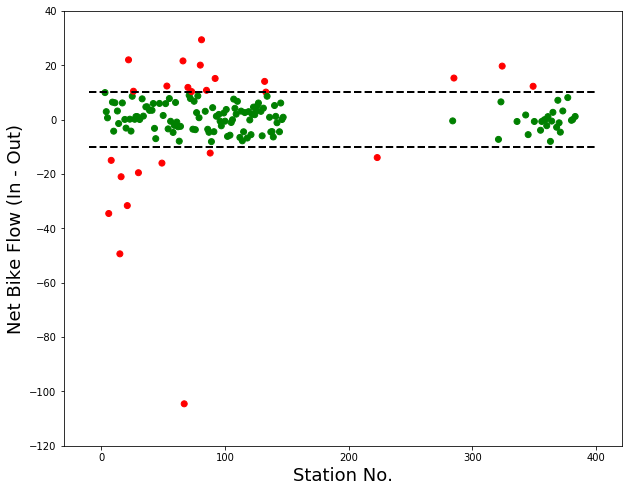

In [105]:
x = bike_flow.index
y = bike_flow['net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.ylim(-120,40)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

In [106]:
#Create source dataframe, with all stations that have large in-traffic
source_flow = bike_flow[bike_flow['net']>maxflow]
source_flow['net']

22     22.002025
26     10.454267
53     12.359233
66     21.604388
70     11.864577
73     10.323896
80     20.059266
81     29.384088
85     10.793502
92     15.154595
132    14.071705
133    10.137044
285    15.301824
324    19.699290
349    12.276099
Name: net, dtype: float64

In [107]:
source_flow.shape[0]

15

In [108]:
#Create sink dataframe, with all stations that have large out-traffic
sink_flow = bike_flow[bike_flow['net']<minflow]
sink_flow['net']

6      -34.531287
8      -14.979113
15     -49.375599
16     -21.011031
21     -31.625091
30     -19.523631
49     -15.987738
67    -104.550635
88     -12.295251
223    -13.948610
Name: net, dtype: float64

In [109]:
sink_flow.shape[0]

10

# Calculate Distances Between Relevant Stations

In [110]:
#Get locations of all stations (for distance calculation)
path2 = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trip_summary_201901.csv"
locations = pd.read_csv(path2)
cols = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
locations = locations[cols].drop_duplicates().set_index('start_station_id').sort_index()
locations.head()

,start_station_latitude,start_station_longitude
start_station_id,,
3,37.786375,-122.404904
4,37.785881,-122.408915
5,37.783899,-122.408445
6,37.804770,-122.403234
7,37.804562,-122.271738


In [111]:
#Function to calculate distance between two stations
def distance(station1id, station2id):
    a = locations.loc[station1id].values
    b = locations.loc[station2id].values
    return np.linalg.norm(a-b)

In [112]:
#Build a DataFrame of distances for all source-sink combinations
distances = pd.DataFrame(columns=['source','sink','distance'])
for i in df_source.index:
    for j in df_sink.index:
        distances = distances.append({'source': int(i), 'sink': int(j), 'distance': distance(i,j)}, ignore_index=True)
distances.head()

,source,sink,distance
0,22.0,6.0,0.017298
1,22.0,8.0,0.010911
2,22.0,15.0,0.005653
3,22.0,16.0,0.004379
4,22.0,21.0,0.006169


In [113]:
#Pivot data for more organized format
distances = distances.pivot(index='source',columns='sink',values='distance')
distances

sink,6.0,8.0,15.0,16.0,21.0,30.0,49.0,67.0,88.0,223.0
source,,,,,,,,,,
22.0,0.017298,0.010911,0.005653,0.004379,0.006169,0.013174,0.009003,0.013147,0.026095,0.035667
26.0,0.019594,0.013324,0.008104,0.006840,0.006842,0.010730,0.006558,0.010712,0.024470,0.034182
53.0,0.044990,0.046012,0.047717,0.047007,0.039416,0.042501,0.043058,0.042257,0.026715,0.020924
66.0,0.028064,0.021986,0.016714,0.015481,0.013549,0.003325,0.003022,0.003490,0.020888,0.030714
70.0,0.051725,0.052957,0.054741,0.054034,0.046442,0.049121,0.049863,0.048880,0.032732,0.025666
73.0,0.044901,0.045064,0.046017,0.045185,0.037419,0.038725,0.039743,0.038488,0.022053,0.015324
80.0,0.030099,0.024742,0.020415,0.019133,0.014781,0.002550,0.006043,0.002371,0.015207,0.024956
81.0,0.030593,0.024661,0.019539,0.018293,0.015726,0.002231,0.005208,0.002476,0.019456,0.029125
85.0,0.043303,0.042784,0.043154,0.042239,0.034429,0.034495,0.035796,0.034263,0.017430,0.010509


In [114]:
#Exported to csv: distances, source_flow, sink_flow

# AMPL Optimization

AMPL model looks like this:

```
set source; set sink;

var x{source, sink} >= 0;

param distance{source, sink};
param sourceflow{source};
param sinkflow{sink};

minimize total_cost: sum{i in source, j in sink} distance[i,j] * x[i,j];

subject to source_goal{i in source}:  sum{j in sink} -x[i,j] + sourceflow[i] <=  10;
subject to source_limit{i in source}: sum{j in sink} -x[i,j] + sourceflow[i] >= -10;
subject to sink_goal{j in sink}:      sum{i in source}  x[i,j] + sinkflow[j] >= -10;
subject to sink_limit{j in sink}:     sum{i in source}  x[i,j] + sinkflow[j] <=  10;
```

And the data file:

```
set source := so22 so26 so53 so66 so70 so73 so80 so81 so85 so92 so132 so133 so285 so324 so349;
set sink := si6 si8 si15 si16 si21 si30 si49 si67 si88 si223;

param distance: si6 si8 si15 si16 si21 si30 si49 si67 si88 si223 :=
so22	0.017298	0.010911	0.005653	0.004379	0.006169	0.013174	0.009003	0.013147	0.026095	0.035667
so26	0.019594	0.013324	0.008104	0.006840	0.006842	0.010730	0.006558	0.010712	0.024470	0.034182
so53	0.044990	0.046012	0.047717	0.047007	0.039416	0.042501	0.043058	0.042257	0.026715	0.020924
so66	0.028064	0.021986	0.016714	0.015481	0.013549	0.003325	0.003022	0.003490	0.020888	0.030714
so70	0.051725	0.052957	0.054741	0.054034	0.046442	0.049121	0.049863	0.048880	0.032732	0.025666
so73	0.044901	0.045064	0.046017	0.045185	0.037419	0.038725	0.039743	0.038488	0.022053	0.015324
so80	0.030099	0.024742	0.020415	0.019133	0.014781	0.002550	0.006043	0.002371	0.015207	0.024956
so81	0.030593	0.024661	0.019539	0.018293	0.015726	0.002231	0.005208	0.002476	0.019456	0.029125
so85	0.043303	0.042784	0.043154	0.042239	0.034429	0.034495	0.035796	0.034263	0.017430	0.010509
so92	0.034036	0.028194	0.023121	0.021874	0.018993	0.004853	0.008684	0.005007	0.018836	0.028093
so132	0.057883	0.055730	0.054305	0.053160	0.045772	0.039946	0.042868	0.039780	0.023522	0.014496
so133	0.052637	0.050057	0.048282	0.047109	0.039885	0.033429	0.036441	0.033268	0.017467	0.009593
so285	0.035089	0.036537	0.038815	0.038229	0.030955	0.036538	0.036274	0.036290	0.023656	0.021777
so324	0.017301	0.015359	0.015987	0.015258	0.007833	0.017677	0.015499	0.017467	0.018547	0.026221
so349	0.023884	0.020245	0.018392	0.017274	0.009889	0.011282	0.010680	0.011042	0.012541	0.021725
;

param sourceflow:=
so22     22.002025
so26     10.454267
so53     12.359233
so66     21.604388
so70     11.864577
so73     10.323896
so80     20.059266
so81     29.384088
so85     10.793502
so92     15.154595
so132    14.071705
so133    10.137044
so285    15.301824
so324    19.699290
so349    12.276099
;

param sinkflow:=
si6      -34.531287
si8      -14.979113
si15     -49.375599
si16     -21.011031
si21     -31.625091
si30     -19.523631
si49     -15.987738
si67    -104.550635
si88     -12.295251
si223    -13.948610
;
```

# Result

In [115]:
path3 = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/model/Optimization/optimized_flow.csv"
optimized_flow = pd.read_csv(path3)
optimized_flow = optimized_flow.pivot(index='source',columns='sink',values='added_flow')
optimized_flow

sink,6,8,15,16,21,30,49,67,88,223
source,,,,,,,,,,
22,0.00000,0.00000,20.9910,11.011,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
26,0.00000,2.06966,18.3846,0.000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
53,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,0.00000,0.00000,2.29525,0.063982
66,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,5.98774,25.61670,0.00000,0.000000
70,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,0.00000,0.00000,0.00000,1.864580
73,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,0.00000,0.00000,0.00000,0.323896
80,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,0.00000,30.05930,0.00000,0.000000
81,0.00000,0.00000,0.0000,0.000,0.00000,9.52363,0.00000,29.86050,0.00000,0.000000
85,0.00000,0.00000,0.0000,0.000,0.00000,0.00000,0.00000,0.00000,0.00000,0.793502


In order to improve the balance of stations, operators can take a number of bikes from `source` stations, specified above, and transport them to the corresponding `sink` stations. This particular arrangement ensures all stations experience no net flow outside of the range of (-10,10) bikes per day.

In [116]:
#Change in flow expected by implementing this solution. Note: Negative numbers mean bike out-flow
net_flow_change = (optimized_flow).sum(axis=0).append(-optimized_flow.sum(axis=1)).rename('added_flow')
net_flow_change

6      24.531320
8       4.979110
15     39.375600
16     11.011000
21     21.625080
30      9.523630
49      5.987740
67     94.550760
88      2.295250
223     7.254704
22    -32.002000
26    -20.454260
53     -2.359232
66    -31.604440
70     -1.864580
73     -0.323896
80    -30.059300
81    -39.384130
85     -0.793502
92     -9.014260
132    -4.071700
133    -0.137044
285    -5.301820
324   -29.699330
349   -14.064700
Name: added_flow, dtype: float64

In [117]:
#New bike flow after flow change
bike_flow = pd.concat([bike_flow, net_flow_change], axis=1).fillna(value=0)
bike_flow['new_net'] = bike_flow['net'] + bike_flow['added_flow']
bike_flow.head()

,bikes_out,bikes_in,net,added_flow,new_net
3,153.302030,143.346334,9.955697,0.00000,9.955697
4,35.120508,32.180798,2.939711,0.00000,2.939711
5,103.705740,103.043821,0.661919,0.00000,0.661919
6,111.785342,146.316629,-34.531287,24.53132,-9.999967
8,39.156881,54.135994,-14.979113,4.97911,-10.000003


In [121]:
#All stations with a change in net flow
bike_flow[bike_flow['added_flow']!=0]

,bikes_out,bikes_in,net,added_flow,new_net
6,111.785342,146.316629,-34.531287,24.531320,-9.999967
8,39.156881,54.135994,-14.979113,4.979110,-10.000003
15,137.367035,186.742634,-49.375599,39.375600,-9.999999
16,108.427759,129.438790,-21.011031,11.011000,-10.000031
21,163.905258,195.530350,-31.625091,21.625080,-10.000011
22,138.556714,116.554689,22.002025,-32.002000,-9.999975
26,35.923481,25.469214,10.454267,-20.454260,-9.999993
30,147.463533,166.987164,-19.523631,9.523630,-10.000001
49,53.922288,69.910026,-15.987738,5.987740,-9.999998
53,31.359194,18.999961,12.359233,-2.359232,10.000001


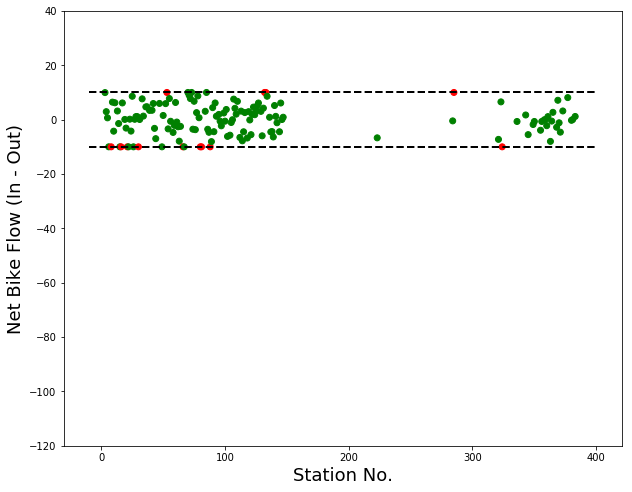

In [119]:
x = bike_flow.index
y = bike_flow['new_net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.ylim(-120,40)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

Through optimization, the flow of bikes is now much more manageable. All stations experience a net flow of anywhere between -10 and 10 bikes per day.